# **ego-Facebook Network Graph**

The ego-Facebook dataset, sourced from the Stanford Network Analysis Project (SNAP), consists of 4,039 nodes and 88,234 edges representing anonymized social circles and friends lists. It is a moderate scale and high density data set we can use to visualize the network and test computational performance in Python. We will calculate and interpret the network diameter and betweenness centrality, to identify the primary informatin brokers and communication paths within the social graph.

**Source:** https://snap.stanford.edu/data/ego-Facebook.html

<br>

### **Computational Requirements & Environment Configuration**
We use **NetworkX ** for the graph calculations and **Matplotlib** for static visualizations. While both metrics are natively supported by NetworkX, the **Betweenness Centrality** calculation presented a significant performance bottleneck, requiring 10 minutes to complete using the default CPU-bound processes.

To improve performance, we reconfigured the Google notebook runtime to use an A100 GPU with High-RAM. By mplementing a GPU-accelerated backend, we offloaded the computationally intensive Betweeness Centrality calculation from the CPU to the GPU, reducing the processing time for the Betweenness metric from 10 minutes to approximately 10 seconds.

In [1]:
#@title Install GPU Acceleration Package

# Install the nx-cugraph extension and its dependencies from the NVIDIA Python Package Index.
!pip install nx-cugraph-cu12 --extra-index-url https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


### Load and Verify the dataset

We use the combined text file dataset available from the SNAP libary for the network graph.  As noted, the number of of nodes and edges match the source:


Node: 4,039
Edges: 88,234




In [2]:
# Import Libraries
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


# Define the URL for the dataset - ego-facebook
url = 'https://raw.githubusercontent.com/johnnydrodriguez/data620/refs/heads/main/facebook_combined.txt'

# Load the data from the URL
df = pd.read_csv(url, sep=' ', names=['source', 'target'])

# Create a NetworkX graph object from the DataFrame
G = nx.from_pandas_edgelist(df, 'source', 'target')

# Print the number of nodes and edges to verify loading
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 4039
Number of edges: 88234


### Diameter Metric

The diameter of a network represents the maximum distance between its two most distant members. It is the longest possible chain of nodes required to travel from one side of the network to the furthest point on the other. A small diameter indicates a tight network where information can circulate rapidly, while a large diameter often signals a fragmented structure with significant delays as information traverses the network.

The results demonstrate that the ego-Facebook network is a "Small-World" system characterized by structural efficiency. The 50th percentile (median) of 4.0 hops indicates that half of all possible connections in this 4,039-node network require four or fewer connections to bridge, while the 90th percentile of 5.0 hops indicates that the vast majority of the network is tightly connected. The leap from a 90th percentile of 5.0 to a full diameter of 8.0 suggests that while the core of the network is compact, there is a long tail of peripheral nodes further away from this core in the last 10% of the network.


In [3]:
# Identify the largest connected component
largest_cc_nodes = max(nx.connected_components(G), key=len)
largest_cc = G.subgraph(largest_cc_nodes).copy()

# Diameter of LCC

print("Calculating diameter (using default CPU backend)...")
# Calculate diameter
diameter = nx.diameter(largest_cc)
print(f"Diameter of the largest connected component: {diameter}")

# Diameter Distributions of LCC

print("\n Analyzing shortest path distributions...")
# Extract all shortest path lengths as a list of integers
path_lengths = []
for node, paths in nx.all_pairs_shortest_path_length(largest_cc):
    path_lengths.extend(paths.values())

#  Filter out zero distances (distance from a node to itself)
path_lengths = [d for d in path_lengths if d > 0]

# Calculate Percentiles
# Diameter (100%) is the full diameter in this distribution.
percentiles = [25, 50, 75, 90, 100]
results = np.percentile(path_lengths, percentiles)

# Display Results
print("\n Network Path Length Distribution")
for p, val in zip(percentiles, results):
    label = "Diameter (Full)" if p == 100 else f"{p}th Percentile"
    print(f"{label}: {val:.1f} hops")

Calculating diameter (using default CPU backend)...
Diameter of the largest connected component: 8

 Analyzing shortest path distributions...

 Network Path Length Distribution
25th Percentile: 3.0 hops
50th Percentile: 4.0 hops
75th Percentile: 4.0 hops
90th Percentile: 5.0 hops
Diameter (Full): 8.0 hops


### Diameter Distribution

The ego-Facebook dataset indicates that the vast majority of its 4,039 members are separated by only a few degrees. The distribution of approximately 16.3 million potential communication paths peaks at 4 hops, indicating that most users can reach one another through just three intermediate friends. While the maximum diameter is 8 hops, the 90th percentile effective diameter of 5 hops shows that the network's core is compact; the hops required to reach the full diameter only apply to 10% of the nodes.

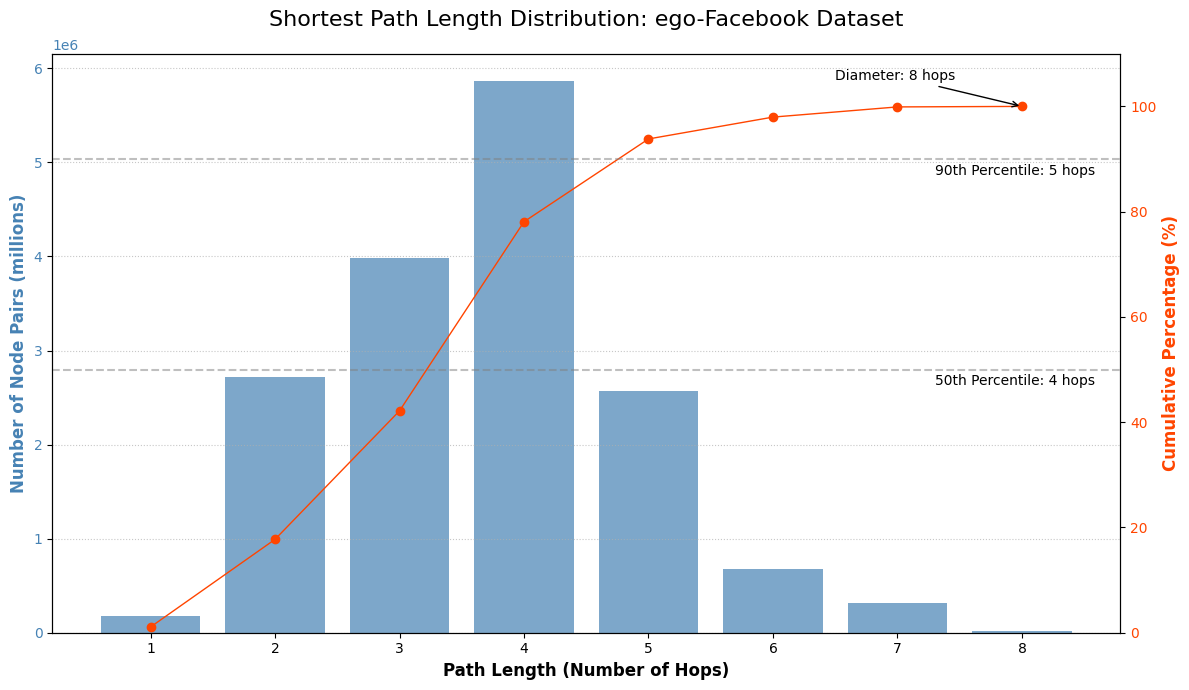

In [4]:
# Frequency Analysis
counts = Counter(path_lengths)
hops = sorted(counts.keys())
frequencies = [counts[h] for h in hops]
total_pairs = sum(frequencies)

# Cumulative Distribution Calculation
cumulative_freq = np.cumsum(frequencies) / total_pairs * 100

# Initialize plot
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot Histogram
color_hist = 'steelblue'
ax1.bar(hops, frequencies, color=color_hist, alpha=0.7, label='Frequency (Count)')
ax1.set_xlabel('Path Length (Number of Hops)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Node Pairs (millions)', fontsize=12, fontweight='bold', color=color_hist)
ax1.tick_params(axis='y', labelcolor=color_hist)
ax1.set_xticks(hops)

# Plot CDF
ax2 = ax1.twinx()
color_cdf = 'orangered'
ax2.plot(hops, cumulative_freq, color=color_cdf, marker='o', linewidth=1, label='CDF (%)')
ax2.set_ylabel('Cumulative Percentage (%)', fontsize=12, fontweight='bold', color=color_cdf)
ax2.tick_params(axis='y', labelcolor=color_cdf)
ax2.set_ylim(0, 110)

# Annotate 50th Percentile
ax2.axhline(50, color='gray', linestyle='--', alpha=0.5)
plt.annotate(f'50th Percentile: 4 hops', xy=(5, 90), xytext=(7.3, 47), fontsize=10)

# Annotate 90th Percentile
ax2.axhline(90, color='gray', linestyle='--', alpha=0.5)
plt.annotate(f'90th Percentile: 5 hops', xy=(5, 90), xytext=(7.3, 87), fontsize=10)

# Diameter
plt.annotate(f'Diameter: 8 hops', xy=(8, 100), xytext=(6.5, 105),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=10)

# Format and display
plt.title('Shortest Path Length Distribution: ego-Facebook Dataset', fontsize=16, pad=20)
ax1.grid(axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

### Betweeness Centrality

Betweenness Centrality measures how much a specific node acts as a **bridge** or **broker** within a system. It is a critical junction that controls the flow of information.  The nodes represent 'brokers' allowing large portions of information to flow through them.

These nodes identify points of system vulnerability and control. A node with high betweenness represents a potential single point of failure; if it removed from the network, communication between large sections of the network is severed.

The results identify the power brokers in the ego-Facebook network. **Node 107 ** is the most vital bridge; with a score of 0.48, it sits on nearly half of all the shortest paths between any two points in the system. 48% of the information or traffic moving through the network relies on Node 107 to get where it's going efficiently.

**Node 1684 (0.34) **and **Node 3437 (0.24)** are your secondary and tertiary gatekeepers. From a network perspective, these top ten nodes are potential single points of failure.  If Node 107 or 1684 goes offline (is removed from the network), large sections could become completely cut off from one another.

In [5]:
print("Calculating betweenness centrality using GPU backend...")
# Calculate betweenness centrality with GPU acceleration
betweenness = nx.betweenness_centrality(G, backend='cugraph')

# Sort and print top 5 nodes
top_10_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 nodes by betweenness centrality:")
for node, centrality in top_10_betweenness:
    print(f"Node {node}: {centrality:.4f}")

Calculating betweenness centrality using GPU backend...

Top 10 nodes by betweenness centrality:
Node 107: 0.4805
Node 1684: 0.3378
Node 3437: 0.2361
Node 1912: 0.2293
Node 1085: 0.1490
Node 0: 0.1463
Node 698: 0.1153
Node 567: 0.0963
Node 58: 0.0844
Node 428: 0.0643


# Network Graph Visualization

This visualization shows the core skeleton of your network for 1000 nodes, highlighting the t**op 10 key brokers** that facilitate communication across the entire system. Each blue circle  node correspnds to its influence; the larger the circle, the more critical that node is as a bridge between different clusters. **Node 107** stands out as the most prominent anchor point in the center of the graph, effectively serving as the primary gateway that connects multiple disparate sections of the network.   While this node is a highly efficient router for information, it also represents the network's most significant vulnerability; if Node 107 were to be removed, the majority of the surrounding clusters would lose their most direct connection to the rest of the network.

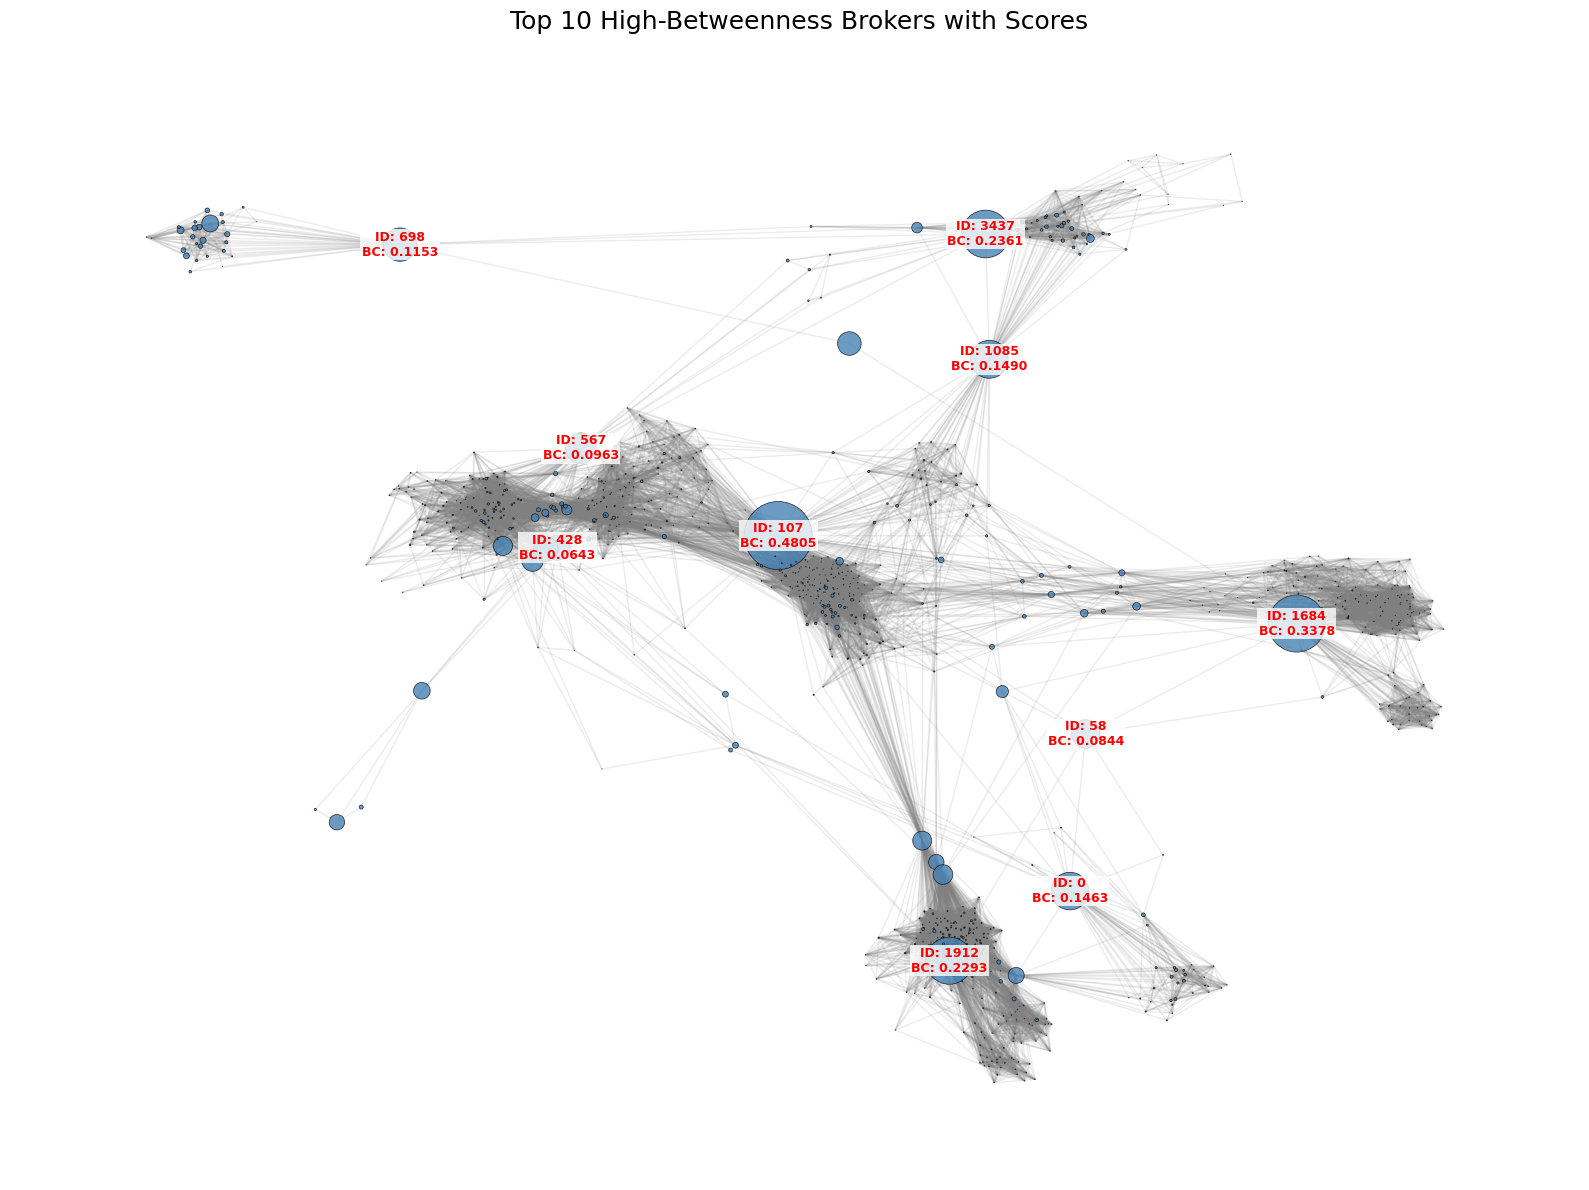

In [6]:
#Import Library
import matplotlib.pyplot as plt

# Extract the top 1,000 nodes by betweenness centrality to create a core subgraph of key brokers.
TOP_N = 1000
top_broker_nodes = sorted(betweenness, key=betweenness.get, reverse=True)[:TOP_N]
G_core = G.subgraph(top_broker_nodes).copy()

# Define the layout coordinates
pos = nx.spring_layout(G_core, k=0.15, iterations=50, seed=42)

# Extract Top 10 Brokers for Labelling with Scores
top_10_brokers = sorted(betweenness, key=betweenness.get, reverse=True)[:10]

# Create labels
broker_labels = {node: f"ID: {node}\nBC: {betweenness[node]:.4f}" for node in top_10_brokers}

# Initialize the Matplotlib figure
plt.figure(figsize=(16, 12))
plt.title(" Top 10 High-Betweenness Brokers with Scores", fontsize=18, pad=20)

# Draw Edges
nx.draw_networkx_edges(G_core, pos, alpha=0.15, edge_color="gray")

# Draw Nodes
node_sizes = [betweenness[n] * 5000 for n in G_core.nodes()]
nx.draw_networkx_nodes(
    G_core, pos,
    node_size=node_sizes,
    node_color="steelblue",
    alpha=0.8,
    edgecolors="black",
    linewidths=0.5)

#  Boker Labels
nx.draw_networkx_labels(
    G_core, pos,
    labels=broker_labels,
    font_size=9,
    font_color='red',
    font_weight="bold",
    bbox=dict(facecolor="white", edgecolor="none", alpha=0.8, pad=1))

# Display Plot
plt.axis("off")
plt.tight_layout()
plt.show()